In [25]:
! pip install resampy

In [26]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import resampy # Though librosa uses it, explicit import is good practice
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print("Imports successful!")

Imports successful!


In [27]:
# --- Configuration ---
# For Mel Spectrograms
N_MELS = 128  # Number of Mel bands (this will be our "num_rows")
FMAX = 8000   # Maximum frequency for Mel bands
# TIME_FRAMES_MAX_LEN is for the time axis (columns), remains the same or adjust as needed
TIME_FRAMES_MAX_LEN = 174 # Max length for the time axis of the spectrogram

# Data processing limits (set to None to process all files, otherwise set a number like 500 for testing)
# num_rows_to_process = 500
num_rows_to_process = None


# Paths
fulldatasetpath = "/kaggle/input/urban-8k-dataset/UrbanSound8K/audio"
metadata_path = '/kaggle/input/urban-8k-dataset/UrbanSound8K/metadata/UrbanSound8K.csv'
SAVED_MODEL_DIR = 'saved_models_pytorch_melspec' # New directory for this version
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

print("Configuration set.")
print(f"Number of Mel bands (N_MELS): {N_MELS}")
print(f"Max time frames (TIME_FRAMES_MAX_LEN): {TIME_FRAMES_MAX_LEN}")
print(f"Number of files to process: {'All' if num_rows_to_process is None else num_rows_to_process}")

Configuration set.
Number of Mel bands (N_MELS): 128
Max time frames (TIME_FRAMES_MAX_LEN): 174
Number of files to process: All


In [28]:
# --- Feature Extraction (Now for Mel Spectrograms) ---
def extract_features_mel_spectrogram(file_name, n_mels=N_MELS, fmax=FMAX, max_len=TIME_FRAMES_MAX_LEN, return_audio_sr=False):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmax=fmax)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        pad_width = max_len - log_mel_spectrogram.shape[1]
        if pad_width < 0:
            log_mel_spectrogram = log_mel_spectrogram[:, :max_len]
        else:
            log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')

        if return_audio_sr:
            return log_mel_spectrogram, audio, sample_rate
        else:
            return log_mel_spectrogram

    except Exception as e:
        # print(f"Error encountered while parsing file for Mel Spectrogram: {file_name}. Error: {e}") # Less verbose
        if return_audio_sr:
            return None, None, None
        else:
            return None

In [29]:
# --- Function to plot Spectrogram (Mel) ---
def plot_mel_spectrogram(file_path, class_label="Unknown"):
    # print(f"\nPlotting Mel Spectrogram for: {os.path.basename(file_path)} (Class: {class_label})") # Less verbose during bulk plotting
    try:
        log_mel_spec, audio, sr = extract_features_mel_spectrogram(file_path, return_audio_sr=True)

        if log_mel_spec is None:
            # print("Could not extract Mel Spectrogram for plotting.") # Less verbose
            return

        fig, ax = plt.subplots(figsize=(10, 4))
        img = librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel', ax=ax, fmax=FMAX)
        ax.set_title(f'Mel Spectrogram (dB) - {class_label} ({os.path.basename(file_path)})')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing and plotting Mel Spectrogram for {file_path}: {e}")

In [30]:
# --- Function to compare Normal vs Mel Spectrograms ---
def plot_spectrograms_side_by_side(file_path, class_label="Unknown"):
    print(f"\nComparing Spectrograms for: {os.path.basename(file_path)} (Class: {class_label})")
    try:
        # Load audio
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')

        # 1. Normal Spectrogram (STFT)
        stft_spectrogram = librosa.stft(audio)
        log_stft_spectrogram = librosa.amplitude_to_db(np.abs(stft_spectrogram), ref=np.max)

        # 2. Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS, fmax=FMAX)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

        # Normal Spectrogram plot
        img1 = librosa.display.specshow(log_stft_spectrogram, sr=sr, x_axis='time', y_axis='hz', ax=ax1)
        ax1.set_title(f'Normal Spectrogram (Hz scale)')
        fig.colorbar(img1, ax=ax1, format='%+2.0f dB')

        # Mel Spectrogram plot
        img2 = librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', ax=ax2, fmax=FMAX)
        ax2.set_title(f'Mel Spectrogram (Mel scale)')
        fig.colorbar(img2, ax=ax2, format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating comparison plot for {file_path}: {e}")

print("Helper functions defined.")

Helper functions defined.


In [31]:
metadata_df_global = pd.read_csv(metadata_path)
print("Metadata columns:", metadata_df_global.columns)
print(f"Total rows in metadata: {len(metadata_df_global)}")
print(f"Number of unique classes: {metadata_df_global['class'].nunique()}")

print("\nClass-wise distribution of samples in the full metadata:")
print(metadata_df_global['class'].value_counts()) # Added this line

Metadata columns: Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'],
      dtype='object')
Total rows in metadata: 8732
Number of unique classes: 10

Class-wise distribution of samples in the full metadata:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64



Comparing Spectrograms for: 100032-3-0-0.wav (Class: dog_bark)


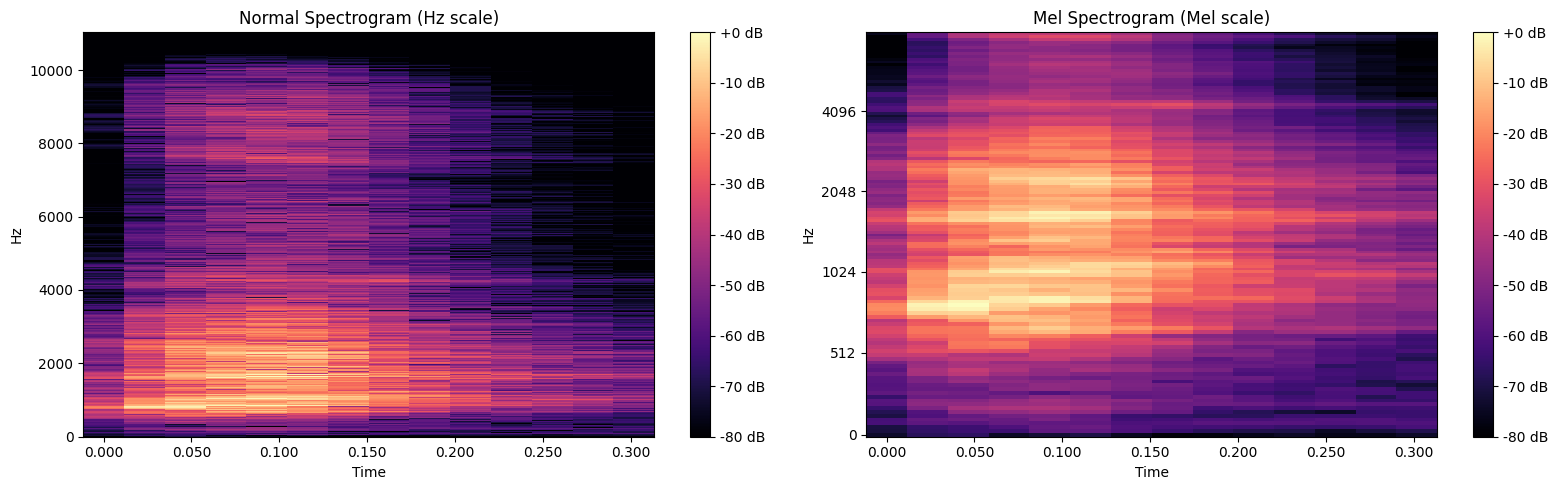

In [32]:
# --- Plot side-by-side comparison for a sample file ---
if not metadata_df_global.empty:
    sample_row = metadata_df_global.iloc[0]
    sample_file_path = os.path.join(fulldatasetpath, f"fold{sample_row['fold']}", sample_row['slice_file_name'])
    if os.path.exists(sample_file_path):
        plot_spectrograms_side_by_side(sample_file_path, class_label=sample_row['class'])
    else:
        print(f"Sample file for comparison not found at: {sample_file_path}")

In [33]:
features_list = []
print(f"\nStarting Mel Spectrogram extraction for model training...")
processed_count = 0
for index, row in metadata_df_global.iterrows():
    if num_rows_to_process is not None and index >= num_rows_to_process:
        break
    file_name = os.path.join(os.path.abspath(fulldatasetpath), 'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))

    data = extract_features_mel_spectrogram(file_name) # return_audio_sr is False by default
    if data is not None:
        features_list.append([data, row["class"]])
        processed_count += 1

    if (index + 1) % 100 == 0:
        print(f"Processed {index + 1} metadata rows. Extracted features for {processed_count} files.")

featuresdf = pd.DataFrame(features_list, columns=['feature', 'class_label'])
print(f'\nFinished Mel Spectrogram extraction from {len(featuresdf)} files for model training.')
print(f"Shape of a sample feature: {featuresdf.feature.iloc[0].shape if len(featuresdf) > 0 else 'N/A'}")

# This line is just to display the dataframe in a notebook environment
# featuresdf

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_labels = len(le.classes_)
print(f"Number of unique classes: {num_labels}")
print(f"Classes: {le.classes_}")


Starting Mel Spectrogram extraction for model training...
Processed 100 metadata rows. Extracted features for 100 files.
Processed 200 metadata rows. Extracted features for 200 files.
Processed 300 metadata rows. Extracted features for 300 files.
Processed 400 metadata rows. Extracted features for 400 files.
Processed 500 metadata rows. Extracted features for 500 files.
Processed 600 metadata rows. Extracted features for 600 files.
Processed 700 metadata rows. Extracted features for 700 files.
Processed 800 metadata rows. Extracted features for 800 files.
Processed 900 metadata rows. Extracted features for 900 files.
Processed 1000 metadata rows. Extracted features for 1000 files.
Processed 1100 metadata rows. Extracted features for 1100 files.
Processed 1200 metadata rows. Extracted features for 1200 files.
Processed 1300 metadata rows. Extracted features for 1300 files.
Processed 1400 metadata rows. Extracted features for 1400 files.
Processed 1500 metadata rows. Extracted features 

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Processed 3600 metadata rows. Extracted features for 3600 files.
Processed 3700 metadata rows. Extracted features for 3700 files.
Processed 3800 metadata rows. Extracted features for 3800 files.
Processed 3900 metadata rows. Extracted features for 3900 files.
Processed 4000 metadata rows. Extracted features for 4000 files.
Processed 4100 metadata rows. Extracted features for 4100 files.
Processed 4200 metadata rows. Extracted features for 4200 files.
Processed 4300 metadata rows. Extracted features for 4300 files.
Processed 4400 metadata rows. Extracted features for 4400 files.
Processed 4500 metadata rows. Extracted features for 4500 files.
Processed 4600 metadata rows. Extracted features for 4600 files.
Processed 4700 metadata rows. Extracted features for 4700 files.
Processed 4800 metadata rows. Extracted features for 4800 files.
Processed 4900 metadata rows. Extracted features for 4900 files.
Processed 5000 metadata rows. Extracted features for 5000 files.
Processed 5100 metadata r

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Processed 8400 metadata rows. Extracted features for 8400 files.
Processed 8500 metadata rows. Extracted features for 8500 files.
Processed 8600 metadata rows. Extracted features for 8600 files.
Processed 8700 metadata rows. Extracted features for 8700 files.

Finished Mel Spectrogram extraction from 8732 files for model training.
Shape of a sample feature: (128, 174)
Number of unique classes: 10
Classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


In [34]:
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"x_train_raw shape: {x_train_raw.shape}, y_train_raw shape: {y_train_raw.shape}")
print(f"x_test_raw shape: {x_test_raw.shape}, y_test_raw shape: {y_test_raw.shape}")

x_train_raw shape: (6985, 128, 174), y_train_raw shape: (6985,)
x_test_raw shape: (1747, 128, 174), y_test_raw shape: (1747,)


In [35]:
# PyTorch Dataset
class UrbanSoundDataset(Dataset):
    def __init__(self, features, labels, num_mel_bands, num_time_frames, num_channels=1):
        self.features = features
        self.labels = labels
        self.num_mel_bands = num_mel_bands
        self.num_time_frames = num_time_frames
        self.num_channels = num_channels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].reshape(self.num_channels, self.num_mel_bands, self.num_time_frames)
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [36]:
MODEL_INPUT_NUM_ROWS = N_MELS
MODEL_INPUT_NUM_COLUMNS = TIME_FRAMES_MAX_LEN
num_channels = 1

train_dataset = UrbanSoundDataset(x_train_raw, y_train_raw, MODEL_INPUT_NUM_ROWS, MODEL_INPUT_NUM_COLUMNS, num_channels)
test_dataset = UrbanSoundDataset(x_test_raw, y_test_raw, MODEL_INPUT_NUM_ROWS, MODEL_INPUT_NUM_COLUMNS, num_channels)

# PyTorch DataLoader
num_batch_size = 32 # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=num_batch_size, shuffle=True, num_workers=2, pin_memory=True) # num_workers > 0 for faster loading
test_loader = DataLoader(test_dataset, batch_size=num_batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 6985
Test dataset size: 1747


In [37]:
class AudioCNN(nn.Module):
    def __init__(self, num_labels, num_input_rows, num_input_cols, num_channels):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=3, padding='same')
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16) # Added BatchNorm
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(0.25) # Slightly increased dropout

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.drop3 = nn.Dropout(0.3) # Increased dropout

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.drop4 = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_labels)

    def forward(self, x):
        x = self.drop1(self.pool1(self.bn1(self.relu1(self.conv1(x)))))
        x = self.drop2(self.pool2(self.bn2(self.relu2(self.conv2(x)))))
        x = self.drop3(self.pool3(self.bn3(self.relu3(self.conv3(x)))))
        x = self.drop4(self.pool4(self.bn4(self.relu4(self.conv4(x)))))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

print("AudioCNN model defined.")

AudioCNN model defined.


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = AudioCNN(num_labels=num_labels,
                 num_input_rows=MODEL_INPUT_NUM_ROWS,
                 num_input_cols=MODEL_INPUT_NUM_COLUMNS,
                 num_channels=num_channels).to(device)
print("\nModel Architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda

Model Architecture:
AudioCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(64, 

In [39]:
# Evaluation Function
def evaluate_model(data_loader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy, all_labels, all_preds

print("\nModel, criterion, optimizer, and evaluation function initialized.")


Model, criterion, optimizer, and evaluation function initialized.


In [40]:
num_epochs = 50
best_test_accuracy = 0.0
model_save_path = os.path.join(SAVED_MODEL_DIR, 'weights.best.melspec_cnn.pth')

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

start_time = datetime.now()
print(f"\nStarting training with Mel Spectrograms for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0

    # Evaluation on Test set
    test_loss, test_acc, _, _ = evaluate_model(test_loader, model, criterion, device)

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"Test accuracy improved to {best_test_accuracy*100:.2f}%. Model saved to {model_save_path}")

duration = datetime.now() - start_time
print(f"\nTraining completed in time: {duration}")
print(f"Best Test Accuracy: {best_test_accuracy*100:.2f}%")


Starting training with Mel Spectrograms for 50 epochs...
Epoch [1/50], Train Loss: 1.3347, Train Acc: 52.77%, Test Loss: 1.3814, Test Acc: 54.95%
Test accuracy improved to 54.95%. Model saved to saved_models_pytorch_melspec/weights.best.melspec_cnn.pth
Epoch [2/50], Train Loss: 0.8609, Train Acc: 72.01%, Test Loss: 0.8227, Test Acc: 73.73%
Test accuracy improved to 73.73%. Model saved to saved_models_pytorch_melspec/weights.best.melspec_cnn.pth
Epoch [3/50], Train Loss: 0.6458, Train Acc: 80.19%, Test Loss: 0.9807, Test Acc: 67.89%
Epoch [4/50], Train Loss: 0.5375, Train Acc: 83.48%, Test Loss: 1.0685, Test Acc: 67.77%
Epoch [5/50], Train Loss: 0.4400, Train Acc: 86.23%, Test Loss: 0.4467, Test Acc: 85.63%
Test accuracy improved to 85.63%. Model saved to saved_models_pytorch_melspec/weights.best.melspec_cnn.pth
Epoch [6/50], Train Loss: 0.3740, Train Acc: 88.16%, Test Loss: 0.4913, Test Acc: 83.00%
Epoch [7/50], Train Loss: 0.3416, Train Acc: 89.01%, Test Loss: 0.4024, Test Acc: 86.95

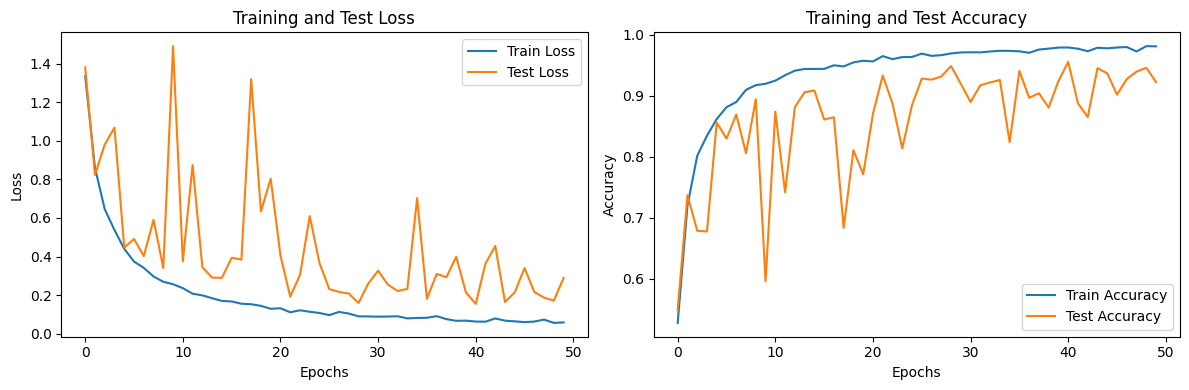

In [41]:
# --- Plotting Training vs. Test Curves ---
plt.figure(figsize=(12, 4))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# --- Loading best model for final evaluation ---
if os.path.exists(model_save_path):
    print(f"\nLoading best model from {model_save_path} for final evaluation...")
    model.load_state_dict(torch.load(model_save_path))
else:
    print(f"\nNo saved model found at {model_save_path}. Evaluating with the current model state (last epoch).")

model.to(device) # Ensure model is on the correct device

# --- Final Evaluation ---
final_train_loss, final_train_acc, y_train_labels, y_train_preds = evaluate_model(train_loader, model, criterion, device)
print(f"Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_acc*100:.2f}%")

final_test_loss, final_test_acc, y_test_labels, y_test_preds = evaluate_model(test_loader, model, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc*100:.2f}%")


Loading best model from saved_models_pytorch_melspec/weights.best.melspec_cnn.pth for final evaluation...
Final Training Loss: 0.0223, Final Training Accuracy: 99.33%
Final Test Loss: 0.1547, Final Test Accuracy: 95.59%



--- Training Confusion Matrix ---


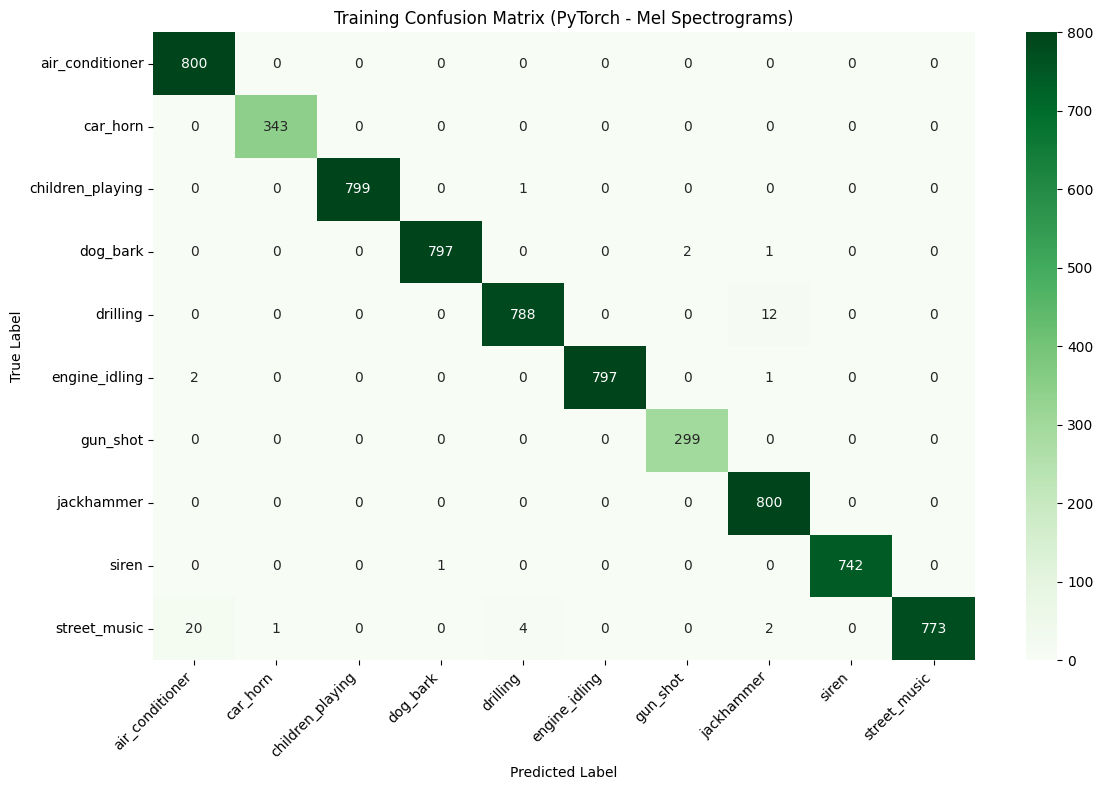


--- Test Confusion Matrix ---


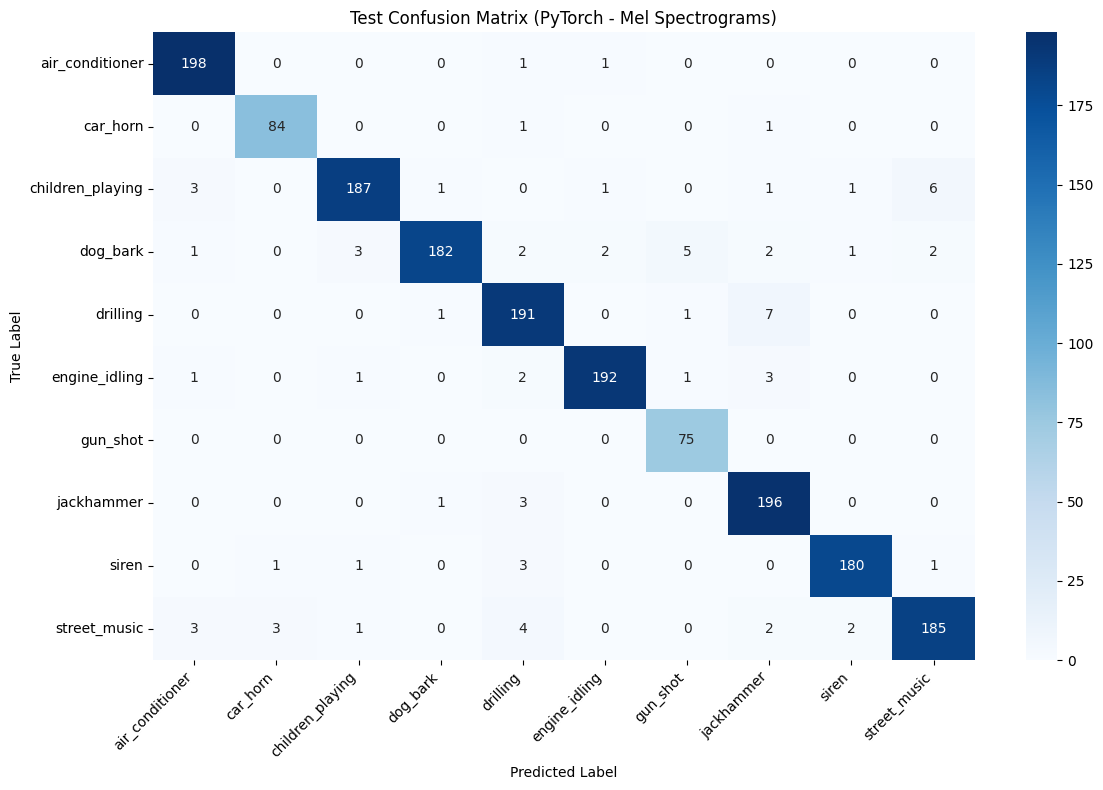


--- Test Classification Report ---
                  precision    recall  f1-score   support

 air_conditioner       0.96      0.99      0.98       200
        car_horn       0.95      0.98      0.97        86
children_playing       0.97      0.94      0.95       200
        dog_bark       0.98      0.91      0.95       200
        drilling       0.92      0.95      0.94       200
   engine_idling       0.98      0.96      0.97       200
        gun_shot       0.91      1.00      0.96        75
      jackhammer       0.92      0.98      0.95       200
           siren       0.98      0.97      0.97       186
    street_music       0.95      0.93      0.94       200

        accuracy                           0.96      1747
       macro avg       0.95      0.96      0.96      1747
    weighted avg       0.96      0.96      0.96      1747



In [43]:
# --- Training Confusion Matrix ---
print("\n--- Training Confusion Matrix ---")
cm_train = confusion_matrix(y_train_labels, y_train_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Confusion Matrix (PyTorch - Mel Spectrograms)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Test Confusion Matrix (Heading Added) ---
print("\n--- Test Confusion Matrix ---")
cm_test = confusion_matrix(y_test_labels, y_test_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix (PyTorch - Mel Spectrograms)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Test Classification Report ---
print("\n--- Test Classification Report ---")
# Define the full set of possible label indices (0 to 9 in this case)
all_label_indices = np.arange(len(le.classes_))
# Generate the report, explicitly providing all possible labels.
# This ensures that even if a class is missing from the test set,
# the report is generated correctly with 0 scores for that class.
report = classification_report(
    y_test_labels,
    y_test_preds,
    target_names=le.classes_,
    labels=all_label_indices,
    zero_division=0
)
print(report)